# Compare clusters when switching off temporal edges of a node

In this notebook, we select a single temporal node and carry out two tests:
- switch off all temporal edges of that node, i.e. setting their weight to a constant value
- switch off all temporal edges except those of that single node

after which we compute clusters of the modified temporal network

In [1]:
import string

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk

## 1. Build temporal network

In [2]:
# load static PPI network
static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)  # networkx Graph object

pk.graph_size_info(static_network)

# load edge time series
edge_activity_filepath = "../data/chen/edge_time_series_normed.csv"
norm = True

# use this for non-normalised time series
# edge_activity_filepath = "data/chen/edge_time_series.csv"
# norm = False

edge_series = pd.read_csv(edge_activity_filepath).transpose()
times = list(edge_series.columns)

# temp_data = TemporalData.from_df(edge_series.transpose(), times, times)

# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)

temporal_network_name = f"kegg_chen_normed_{norm}"

A PartiallyTemporalNetwork is created instead.


## 2. Set parameters for analysis

In [3]:
# reverse_switch = False # if False: switch off all edges of specified node, if True, switch off all other edges

# skips = [2, 5, 10, 15, 20] # number of times to skip to vary sampling frequency
skips = [
    2,
    5,
    10,
    15,
    18,
    20,
]  # number of times to skip to vary sampling frequency

# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # clustering method
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

output_directory = "images/chen/"
if norm:
    output_directory += "normalised/sampling/"
# if reverse_switch :
#     output_directory += 'switchoff_all_but_single_node/'
# else :
#     output_directory += 'switchoff_single_node/'

print(output_directory)

events_times = [5, 33, 36, 70, 84, 100]
events_labels = ["START", "bud", "ori", "E3", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

time_ticks = range(101, 10)

images/chen/normalised/sampling/


## 3. Compare single number of clusters for each selected sampling frequency

### 3.1 Compute clusters for each selected sampling frequency

In [4]:
valid_sets = []

# compute reference clusters
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)
# single number of cluster
cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

# compute modified clusters
for i, skip in enumerate(skips):

    edge_series_downsampled = edge_series.loc[:, ::skip]

    temporal_network_downsampled = (
        pk.TemporalNetwork.from_static_network_and_edge_timeseries(
            static_network,
            edge_series_downsampled,
            static_edge_default_weight=1,
            quiet=True,  # if True, prints less information
        )
    )

    # compute clusters
    distance_matrix_downsampled = pk.DistanceMatrix.from_temporal_network(
        temporal_network_downsampled, distance_metric
    )

    # single number of cluster
    cluster_set_downsampled = pk.ClusterSet.from_distance_matrix(
        distance_matrix_downsampled, n_max_type, n_max, clustering_method
    )

    #     rand_index = adjusted_rand_score(cluster_set.clusters, cluster_set_downsampled.clusters)

    #     valid_sets.append([snapshots_downsampled, cluster_set_downsampled, skip, rand_index])
    valid_sets.append([distance_matrix_downsampled, cluster_set_downsampled, skip])

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.


### 3.2 Plot clusters for each sampling frequency

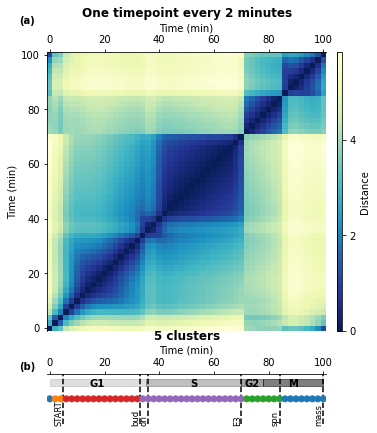

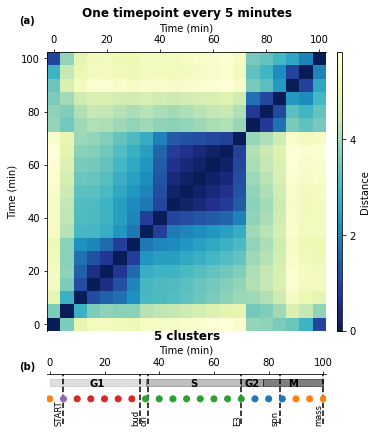

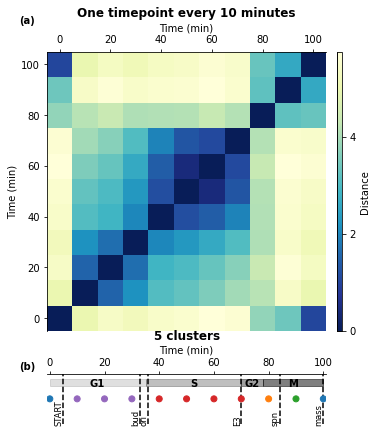

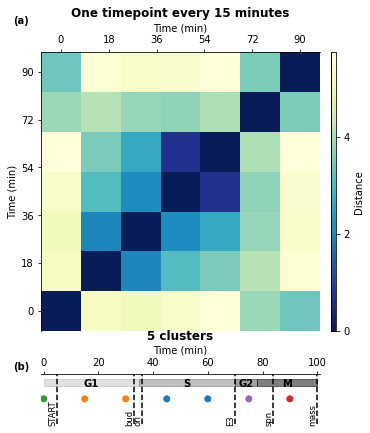

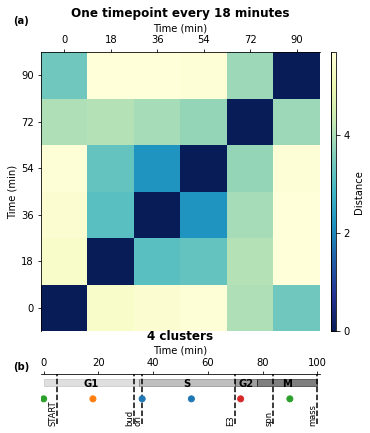

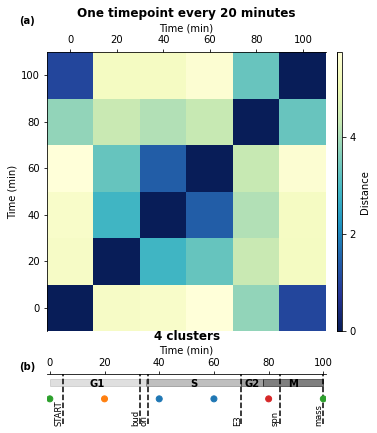

In [21]:
for i, (distance_matrix_downsampled, cluster_set_modified, node) in enumerate(
    valid_sets
):

    skip = skips[i]
    times_modified = distance_matrix_downsampled.times
    n_times = len(times_modified)
    # plot clusters
    pk.configure_sch_color_map(cm.get_cmap("tab10"))
    sb.set_palette("Dark2", n_colors=8)

    gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

    fig, (ax1, ax2) = plt.subplots(
        2, 1, gridspec_kw=gs_kw, sharex=False, figsize=(5, 7)
    )

    # distance matrix
    im = ax1.imshow(
        distance_matrix_downsampled.distance_matrix,
        aspect="equal",
        origin="lower",
        cmap="YlGnBu_r",
    )

    n_ticks = 6
    ticks = np.linspace(0, n_times - 1, num=n_ticks)
    tick_labels = np.linspace(
        times_modified[0], times_modified[-1], num=n_ticks, dtype=int
    )
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.set_xticklabels(tick_labels)
    ax1.set_yticklabels(tick_labels)

    sb.despine(ax=ax1, top=False, bottom=True)

    #     ax1.set_ylim(0, 101)
    ax1.set_ylabel("Time (min)")
    ax1.set_xlabel("Time (min)")
    ax1.xaxis.set_label_position("top")
    ax1.xaxis.set_ticks_position("top")
    #     ax1.set_title(f"Distance matrix with {distance_metric} distance", weight="bold")
    ax1.set_title(f"One timepoint every {skip} minutes", weight="bold")

    # clusters
    cluster_set_modified.plot(ax=ax2)

    sb.despine(ax=ax2, left=True, bottom=True, top=False)
    # only way to get rid of spine offset in scatter plot apparently
    ax2.set_xlim(-1, 101)
    ax2.set_yticks([])
    ax2.set_xlabel("Time (min)")
    ax2.set_title(f"{cluster_set_modified.n_clusters} clusters", weight="bold")

    #     sb.despine(ax=ax2, left=True, bottom=True, top=False)
    ax2.set_xlabel(f"Time (min)")
    ax2.xaxis.set_label_position("top")

    pk.plot_phases(phases, ax=ax2, y_pos=0.8, ymax=0.9, ymin=0.75)
    pk.plot_events(events, ax=ax2, text_y_pos=-0.06, text_x_offset=1.5, va="bottom")

    # plt.subplots_adjust(hspace=-0.1)

    # colorbar
    cax = fig.add_axes((0, 0, 1, 0.1))
    pos1 = ax1.get_position()  # get the original position
    pos2 = [
        pos1.x0 + pos1.width + 0.03,
        pos1.y0,
        pos1.width * 0.02,
        pos1.height,
    ]  # vertical
    cax.set_position(pos2)  # set a new position

    cb = fig.colorbar(im, cax=cax)
    cb.set_ticks([0, 2, 4])
    cb.set_label("Distance")
    sb.despine(ax=cax)

    # label subplots
    for n, ax in enumerate([ax1, ax2]):
        ax.text(
            -0.1,
            1.1,
            f"({string.ascii_lowercase[n]})",
            transform=ax.transAxes,
            size="medium",
            weight="bold",
        )

    # Save
    if output_directory is not None:
        filename = f"{output_directory}distmat_{cluster_set.n_clusters}_sampling_frequency_skip_{skip}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
        #         plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
        #         plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")
        pass

    plt.show()

## 4. Range of number of clusters

### 4.1 Compute clusters

In [22]:
valid_sets = []

# compute modified clusters
for i, skip in enumerate(skips):

    try:
        edge_series_downsampled = edge_series.loc[:, ::skip]

        temporal_network_downsampled = (
            pk.TemporalNetwork.from_static_network_and_edge_timeseries(
                static_network,
                edge_series_downsampled,
                static_edge_default_weight=1,
                quiet=True,  # if True, prints less information
            )
        )

        # compute clusters
        distance_matrix_downsampled = pk.DistanceMatrix.from_temporal_network(
            temporal_network_downsampled, distance_metric
        )

        # single number of cluster
        cluster_sets_downsampled = pk.ClusterSets.from_distance_matrix(
            distance_matrix_downsampled,
            n_max_type,
            n_max_range,
            clustering_method,
        )

        valid_sets.append([distance_matrix_downsampled, cluster_sets_downsampled, skip])

    except Exception as e:
        print(f"Error when skip = {skip}: {e}")

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.


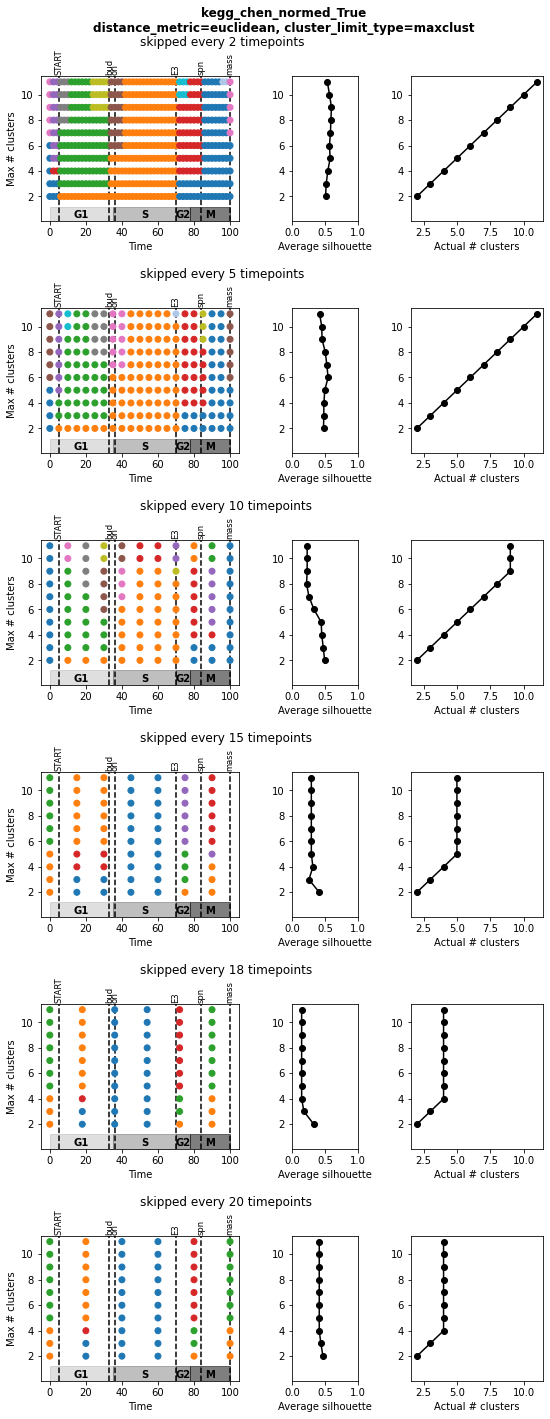

In [23]:
gridspec_kw = {"width_ratios": [3, 1, 2]}
figsize = (9, 4 * len(valid_sets))
fig, axs = plt.subplots(
    len(valid_sets),
    3,
    figsize=figsize,
    gridspec_kw=gridspec_kw,
    sharey="row",
    sharex="col",
)

for i, (distance_matrix_downsampled, cluster_sets, skip) in enumerate(valid_sets):
    row = (axs[i, 0], axs[i, 1], axs[i, 2])
    cluster_sets.plot_and_format_with_average_silhouettes(
        row, events, phases, time_ticks
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    fontdict = {"horizontalalignment": "left"}
    axs[i, 0].set_title(f"skipped every {skip} timepoints", fontdict=fontdict, pad=30)

title = (
    temporal_network_name
    + f"\ndistance_metric={distance_metric}, cluster_limit_type={n_max_type}"
)
fig.suptitle(title, y=0.92, weight="bold")

# Save
if output_directory is not None:
    filename = f"{output_directory}/silhouette_scores_over_sampling_frequency_{pk.slugify(temporal_network_name)}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

In [24]:
clustering_limits = []

for i, (_, cluster_sets, skip) in enumerate(valid_sets):

    #     id_max = np.argmax(cluster_sets.size) # index of maximum number of clusters found
    size_max = max(cluster_sets.n_clusters)  # max number of clusters found
    n_points = cluster_sets.clusters.shape[1]

    id_max_silhouette = np.argmax(cluster_sets.silhouettes_average)
    silhouette_max = cluster_sets.silhouettes_average[id_max_silhouette]
    size_max_silhouette = cluster_sets.n_clusters[id_max_silhouette]

    clustering_limits.append(
        [skip, n_points, size_max_silhouette, silhouette_max, size_max]
    )

clustering_limits = np.array(clustering_limits)

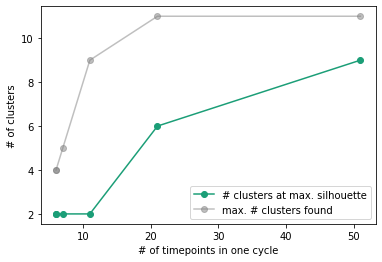

In [25]:
fig, ax = plt.subplots()

ax.plot(
    clustering_limits[:, 1],
    clustering_limits[:, 2],
    "o-",
    label="# clusters at max. silhouette",
)
ax.plot(
    clustering_limits[:, 1],
    clustering_limits[:, 4],
    "o-",
    c="grey",
    label="max. # clusters found",
    alpha=0.5,
)

ax.set_xlabel("# of timepoints in one cycle")
ax.set_ylabel("# of clusters")

ax.legend()


# Save
if output_directory is not None:
    filename = f"{output_directory}/max_clusters_over_sampling_frequency_{pk.slugify(temporal_network_name)}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()